In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from statsmodels.tsa import stattools
from IPython.display import HTML
import datetime
import seaborn as sns

pd.set_option('max_colwidth', 1000)

%run ./ping_helps.ipynb

clean = read_all()

clean['hour'] = clean['tstamp'].apply(lambda x: x.hour)
clean['minute'] = clean['tstamp'].apply(lambda x: x.minute)
clean['second'] = clean['tstamp'].apply(lambda x: x.second)

In [2]:
sf = clean.groupby('hour')['lat'].describe().rename(columns={'75%':'sf'})['sf']
above_q = clean.merge(sf.to_frame(), how='left', on='hour').query('lat > sf')
clean.groupby('hour')['lat'].describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,25815.0,134.647306,232.416099,46.7,48.3,49.8,51.9,2049.0
1,23907.0,143.527268,243.835978,45.4,48.2,49.6,51.8,1040.0
2,21560.0,153.758673,256.529286,45.2,48.1,49.1,51.6,1906.0
3,21539.0,153.316217,252.654945,46.8,48.2,49.2,52.2,1464.0
4,21552.0,153.330563,253.141553,46.7,48.2,49.2,51.7,1415.0
5,21562.0,148.374469,244.847021,46.8,48.1,49.1,51.6,1039.0
6,21555.0,149.151153,247.463500,46.9,48.1,49.1,51.6,1464.0
7,21547.0,148.743370,246.953370,46.8,48.1,49.1,51.7,1460.0
8,23001.0,132.514886,228.294901,46.9,48.1,49.0,51.3,2026.0


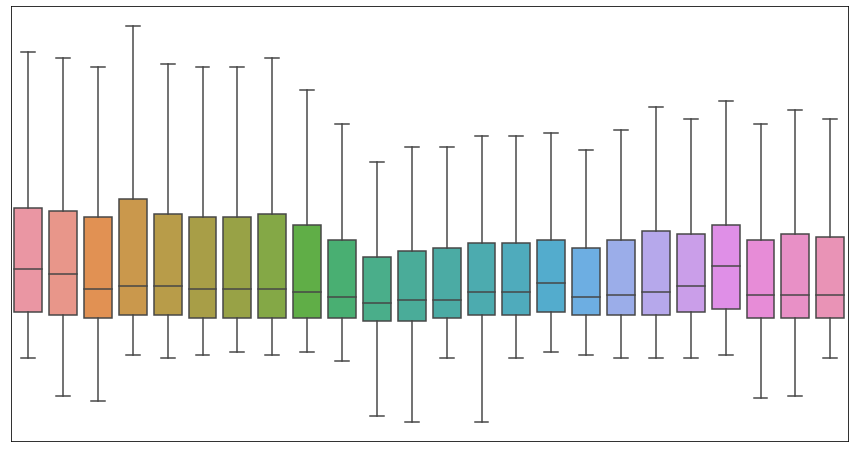

In [3]:
plt.rc('font', size=20)
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="hour", y="lat", data=clean, showfliers=False);
#plt.title('Internet speed to google.com over time.')
plt.xlabel('');
plt.ylabel('')
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
plt.savefig('/home/anthony/personalSite/content/project/internet-traffic/featured.jpg')

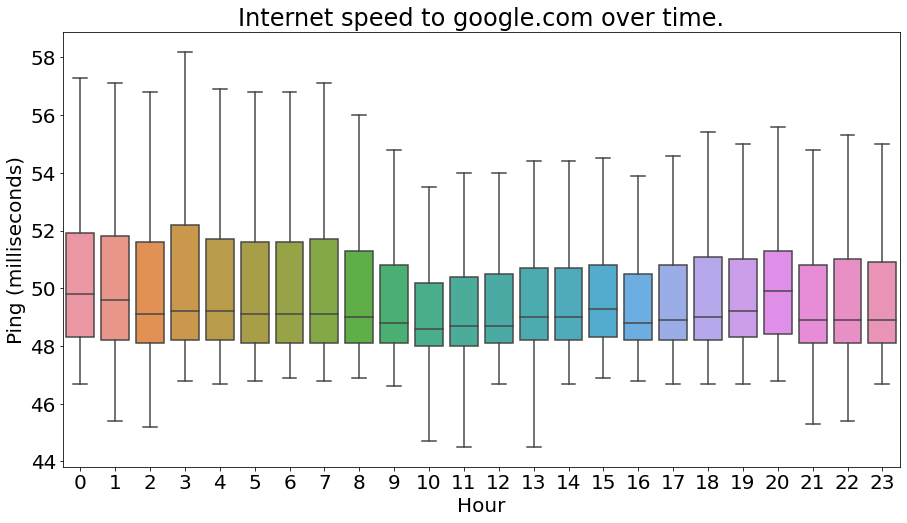

In [3]:
# See docs for whisker ending point (default 1.5 of iqr)
# https://seaborn.pydata.org/generated/seaborn.boxplot.html
plt.rc('font', size=20)
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="hour", y="lat", data=clean, showfliers=False);
plt.title('Internet speed to google.com over time.')
plt.xlabel('Hour');
plt.ylabel('Ping (milliseconds)');

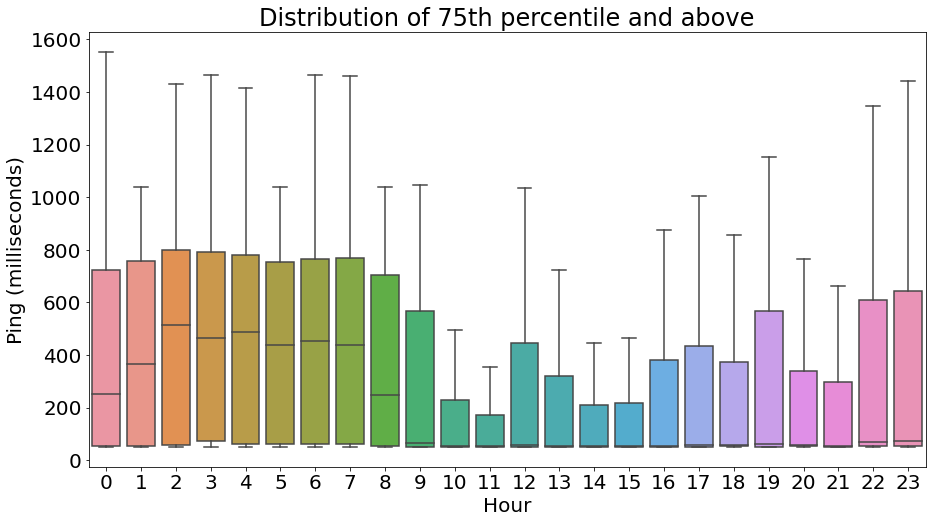

In [5]:
plt.rc('font', size=20)
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="hour", y="lat", data=above_q, showfliers=False);
plt.title('Distribution of 75th percentile and above')
plt.xlabel('Hour');
plt.ylabel('Ping (milliseconds)');